In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from math import log
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn import metrics
import warnings
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

warnings.filterwarnings("ignore", category=FutureWarning )
warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning,FutureWarning))
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None

In [2]:
import tensorflow as tf

In [3]:
data = pd.read_excel('default of credit card clients.xls', skiprows=1)
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

In [4]:
for var in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    data[var] = data[var].apply(lambda x: 0 if x<=0 else x)
    
# Caluclate average payment and log of payment
data['PAY_AMT_AVG']     = data[[col for col in data.columns if col.startswith('PAY_AMT') ]].mean(axis=1)
data['PAY_AMT_AVG_log'] = data['PAY_AMT_AVG'].apply(lambda x: log(x+1))
#
for i in np.arange(1,7):
    data['PAY_REL_AMT_'+str(i)] = data['PAY_AMT'+str(i)]/data['PAY_AMT_AVG']
#
# log of payments
for i in np.arange(1,7):
    data['PAY_REL_AMT_log_'+str(i)] = data['PAY_AMT'+str(i)].apply(lambda x: log(x+1))
    
#Feature Engineering of bill amount
data['BILL_AMT_AVG'] = data[[col for col in data.columns if col.startswith('BILL_AMT')]].mean(axis=1)
data['BILL_AMT_AVG_log'] = data['BILL_AMT_AVG'].apply(lambda x: log(x+1) if x>0 else 0)
#
# bill sign as a separate feature
for i in np.arange(1,7):
    data['BILL_AMT_SIGN_'+str(i)] = data['BILL_AMT'+str(i)].apply(lambda x: float(x>0))
#
#log of credit limit
data['LIMIT_BAL_log'] = data['LIMIT_BAL'].apply(lambda x: log(x+1))
data['LIMIT_BAL_CAT'] = pd.cut(data['LIMIT_BAL'], range(0, np.max(data['LIMIT_BAL']), 10000),  right=False)
#
data['SEX'] = data['SEX'].astype('category').cat.rename_categories(['M', 'F'])
data['MARRIAGE'] = data['MARRIAGE'].astype('category').cat.rename_categories(['NA', 'MARRIED', 'SINGLE', 'OTHER'])
data['AGE_CAT'] = pd.cut(data['AGE'], range(0, 100, 10), right=False)
education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 4:'other', 5:'other', 6:'other'}
data['EDUCATION'] = data['EDUCATION'].apply(lambda i: education_dict[i]) 

In [5]:
data = pd.get_dummies(data, columns=[col for col in data.columns if data[col].dtypes not in ['int64', 'float64']])

In [6]:
data.head(2)

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,PAY_AMT_AVG,PAY_AMT_AVG_log,PAY_REL_AMT_1,PAY_REL_AMT_2,PAY_REL_AMT_3,PAY_REL_AMT_4,PAY_REL_AMT_5,PAY_REL_AMT_6,PAY_REL_AMT_log_1,PAY_REL_AMT_log_2,PAY_REL_AMT_log_3,PAY_REL_AMT_log_4,PAY_REL_AMT_log_5,PAY_REL_AMT_log_6,BILL_AMT_AVG,BILL_AMT_AVG_log,BILL_AMT_SIGN_1,BILL_AMT_SIGN_2,BILL_AMT_SIGN_3,BILL_AMT_SIGN_4,BILL_AMT_SIGN_5,BILL_AMT_SIGN_6,LIMIT_BAL_log,SEX_M,SEX_F,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_NA,MARRIAGE_MARRIED,MARRIAGE_SINGLE,MARRIAGE_OTHER,"LIMIT_BAL_CAT_[0, 10000)","LIMIT_BAL_CAT_[10000, 20000)","LIMIT_BAL_CAT_[20000, 30000)","LIMIT_BAL_CAT_[30000, 40000)","LIMIT_BAL_CAT_[40000, 50000)","LIMIT_BAL_CAT_[50000, 60000)","LIMIT_BAL_CAT_[60000, 70000)","LIMIT_BAL_CAT_[70000, 80000)","LIMIT_BAL_CAT_[80000, 90000)","LIMIT_BAL_CAT_[90000, 100000)","LIMIT_BAL_CAT_[100000, 110000)","LIMIT_BAL_CAT_[110000, 120000)","LIMIT_BAL_CAT_[120000, 130000)","LIMIT_BAL_CAT_[130000, 140000)","LIMIT_BAL_CAT_[140000, 150000)","LIMIT_BAL_CAT_[150000, 160000)","LIMIT_BAL_CAT_[160000, 170000)","LIMIT_BAL_CAT_[170000, 180000)","LIMIT_BAL_CAT_[180000, 190000)","LIMIT_BAL_CAT_[190000, 200000)","LIMIT_BAL_CAT_[200000, 210000)","LIMIT_BAL_CAT_[210000, 220000)","LIMIT_BAL_CAT_[220000, 230000)","LIMIT_BAL_CAT_[230000, 240000)","LIMIT_BAL_CAT_[240000, 250000)","LIMIT_BAL_CAT_[250000, 260000)","LIMIT_BAL_CAT_[260000, 270000)","LIMIT_BAL_CAT_[270000, 280000)","LIMIT_BAL_CAT_[280000, 290000)","LIMIT_BAL_CAT_[290000, 300000)","LIMIT_BAL_CAT_[300000, 310000)","LIMIT_BAL_CAT_[310000, 320000)","LIMIT_BAL_CAT_[320000, 330000)","LIMIT_BAL_CAT_[330000, 340000)","LIMIT_BAL_CAT_[340000, 350000)","LIMIT_BAL_CAT_[350000, 360000)","LIMIT_BAL_CAT_[360000, 370000)","LIMIT_BAL_CAT_[370000, 380000)","LIMIT_BAL_CAT_[380000, 390000)","LIMIT_BAL_CAT_[390000, 400000)","LIMIT_BAL_CAT_[400000, 410000)","LIMIT_BAL_CAT_[410000, 420000)","LIMIT_BAL_CAT_[420000, 430000)","LIMIT_BAL_CAT_[430000, 440000)","LIMIT_BAL_CAT_[440000, 450000)","LIMIT_BAL_CAT_[450000, 460000)","LIMIT_BAL_CAT_[460000, 470000)","LIMIT_BAL_CAT_[470000, 480000)","LIMIT_BAL_CAT_[480000, 490000)","LIMIT_BAL_CAT_[490000, 500000)","LIMIT_BAL_CAT_[500000, 510000)","LIMIT_BAL_CAT_[510000, 520000)","LIMIT_BAL_CAT_[520000, 530000)","LIMIT_BAL_CAT_[530000, 540000)","LIMIT_BAL_CAT_[540000, 550000)","LIMIT_BAL_CAT_[550000, 560000)","LIMIT_BAL_CAT_[560000, 570000)","LIMIT_BAL_CAT_[570000, 580000)","LIMIT_BAL_CAT_[580000, 590000)","LIMIT_BAL_CAT_[590000, 600000)","LIMIT_BAL_CAT_[600000, 610000)","LIMIT_BAL_CAT_[610000, 620000)","LIMIT_BAL_CAT_[620000, 630000)","LIMIT_BAL_CAT_[630000, 640000)","LIMIT_BAL_CAT_[640000, 650000)","LIMIT_BAL_CAT_[650000, 660000)","LIMIT_BAL_CAT_[660000, 670000)","LIMIT_BAL_CAT_[670000, 680000)","LIMIT_BAL_CAT_[680000, 690000)","LIMIT_BAL_CAT_[690000, 700000)","LIMIT_BAL_CAT_[700000, 710000)","LIMIT_BAL_CAT_[710000, 720000)","LIMIT_BAL_CAT_[720000, 730000)","LIMIT_BAL_CAT_[730000, 740000)","LIMIT_BAL_CAT_[740000, 750000)","LIMIT_BAL_CAT_[750000, 760000)","LIMIT_BAL_CAT_[760000, 770000)","LIMIT_BAL_CAT_[770000, 780000)","LIMIT_BAL_CAT_[780000, 790000)","LIMIT_BAL_CAT_[790000, 800000)","LIMIT_BAL_CAT_[800000, 810000)","LIMIT_BAL_CAT_[810000, 820000)","LIMIT_BAL_CAT_[820000, 830000)","LIMIT_BAL_CAT_[830000, 840000)","LIMIT_BAL_CAT_[840000, 850000)","LIMIT_BAL_CAT_[850000, 860000)","LIMIT_BAL_CAT_[860000, 870000)","LIMIT_BAL_CAT_[870000, 880000)","LIMIT_BAL_CAT_[880000, 890000)","LIMIT_BAL_CAT_[890000, 900000)","LIMIT_BAL_CAT_[900000, 910000)","LIMIT_BAL_CAT_[910000, 920000)","LIMIT_BAL_CAT_[920000, 930000)","LIMIT_BAL_CAT_[930000, 940000)","LIMIT_BAL_CAT_[940000, 950000)","LIMIT_BAL_CAT_[950000, 960000)","LIMIT_BAL_CAT_[960000, 970000)","LIMIT_BAL_CAT_[970000, 980000)","LIMIT_BAL_CAT_[980000, 990000)","AGE_CAT_[0, 10)","AGE_CAT_[10, 20)","AGE_CAT_[20, 3

In [7]:
#Imputing the missing values  
for name in data.columns:
    if pd.isnull(data[name]).sum() > 0:
        median = data[name].median()
        data[name] = data[name].apply(lambda x: median if pd.isnull(x) else x)
#
y = data['DEFAULT_NEXT_MONTH']
X = data.drop(['DEFAULT_NEXT_MONTH', 'ID'], axis = 1) 
#
selector = SelectKBest(f_classif, 30)
selector.fit(X, y)
top_indices = np.nan_to_num(selector.scores_).argsort()[-30:][::-1]
selector.scores_[top_indices]
X_prep = X[X.columns[top_indices]]
scaler = preprocessing.MinMaxScaler()
X_transformed = scaler.fit(X_prep).transform(X_prep)
X_transformed_df = pd.DataFrame(X_transformed,columns=X.columns[top_indices])
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.2, random_state=1)

In [8]:
X_train.head(2)

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,LIMIT_BAL_log,PAY_REL_AMT_log_1,LIMIT_BAL,PAY_AMT_AVG_log,PAY_REL_AMT_log_2,PAY_REL_AMT_log_3,PAY_REL_AMT_log_4,PAY_REL_AMT_log_6,PAY_REL_AMT_log_5,PAY_AMT_AVG,"LIMIT_BAL_CAT_[20000, 30000)","LIMIT_BAL_CAT_[30000, 40000)",PAY_AMT1,PAY_AMT2,PAY_AMT4,PAY_AMT3,"LIMIT_BAL_CAT_[10000, 20000)",PAY_AMT5,PAY_AMT6,EDUCATION_graduate school,BILL_AMT_AVG_log,EDUCATION_other,"LIMIT_BAL_CAT_[500000, 510000)",SEX_M
28004,0.125,0.25,0.0,0.0,0.0,0.0,0.150507,0.000000,0.010101,0.647476,0.617825,0.504077,0.738600,0.524260,0.671094,0.009040,1.0,0.0,0.000000,0.004172,0.030596,0.001116,0.0,0.014067,0.001892,0.0,0.713694,0.0,0.0,0.0
8560,0.000,0.00,0.0,0.0,0.0,0.0,0.349475,0.412669,0.040404,0.431403,0.408792,0.420182,0.431731,0.437005,0.444242,0.000504,0.0,0.0,0.000323,0.000208,0.000509,0.000353,0.0,0.000741,0.000598,0.0,0.419512,0.0,0.0,0.0


In [43]:
def plot_weight_posteriors(names, qm_vals, qs_vals, fname=None):
    #qm_vals --> prosterior means of weight varibles
    #qs_vals --> posterior standard deviations of weight varibles
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 2, 1)
    for n, qm in zip(names, qm_vals):
        sns.distplot(qm.flatten(), ax=ax, label=n)
    ax.set_title("weight means")
    ax.set_xlim([-1.5, 1.5])
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    for n, qs in zip(names, qs_vals):
        sns.distplot(qs.flatten(), ax=ax)
    ax.set_title("weight stddevs")
    ax.set_xlim([0, 1.])
    plt.show()
    return(fig)

In [62]:
learning_rate = 0.001
max_steps = 2000
batch_size = 128
viz_steps = 200
num_monte_carlo = 50

In [63]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [96]:
def build_input_pipeline(xTrain, yTrain, xTest, yTest, batch_size, heldout_size):
    # Build an iterator over training batches.
    training_dataset = tf.data.Dataset.from_tensor_slices(
      (xTrain, np.int32(yTrain)))
    training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
    training_iterator = tf.compat.v1.data.make_one_shot_iterator(training_batches)

    # Build a iterator over the heldout set with batch_size=heldout_size,
    # i.e., return the entire heldout set as a constant.
    heldout_dataset = tf.data.Dataset.from_tensor_slices(
      (xTest,
       np.int32(yTest)))
    heldout_frozen = (heldout_dataset.take(heldout_size).
                    repeat().batch(heldout_size))
    heldout_iterator = tf.compat.v1.data.make_one_shot_iterator(heldout_frozen)

    # Combine these into a feedable iterator that can switch between training
    # and validation inputs.
    handle = tf.compat.v1.placeholder(tf.string, shape=[])
    feedable_iterator = tf.compat.v1.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
    data_, labels = feedable_iterator.get_next()

    return data_, labels, handle, training_iterator, heldout_iterator

In [97]:
data_, labels, handle, training_iterator, heldout_iterator = build_input_pipeline(X_train,y_train, X_test, y_test, batch_size, X_test.shape[0])

In [98]:
with tf.compat.v1.name_scope("bayesian_neural_net", values=[data_]):
    neural_net = tf.keras.Sequential([
      tfp.layers.DenseFlipout(8, activation=tf.nn.leaky_relu),
      tfp.layers.DenseFlipout(8, activation=tf.nn.leaky_relu),    
      tf.keras.layers.Dense(2, activation='sigmoid')
        ])

    logits = neural_net(data_)
    labels_distribution = tfd.Categorical(logits=logits)

# Compute the -ELBO as the loss, averaged over the batch size.
neg_log_likelihood = -tf.reduce_mean(
  input_tensor=labels_distribution.log_prob(labels))
kl = sum(neural_net.losses) / X_train.shape[0]
elbo_loss = neg_log_likelihood + kl

# Build metrics for evaluation. Predictions are formed from a single forward
# pass of the probabilistic layers. They are cheap but noisy predictions.
predictions = tf.argmax(input=logits, axis=1)
accuracy, accuracy_update_op = tf.compat.v1.metrics.accuracy(
  labels=labels, predictions=predictions)

In [99]:
# Extract weight posterior statistics for layers with weight distributions
# for later visualization.
names = []
qmeans = []
qstds = []
for i, layer in enumerate(neural_net.layers):
    try:
      q = layer.kernel_posterior
    except AttributeError:
      continue
    names.append("Layer {}".format(i))
    qmeans.append(q.mean())
    qstds.append(q.stddev())
    print()


with tf.compat.v1.name_scope("train"):
    optimizer = tf.compat.v1.train.AdamOptimizer(
        learning_rate=learning_rate)
    train_op = optimizer.minimize(elbo_loss)

init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                 tf.compat.v1.local_variables_initializer())

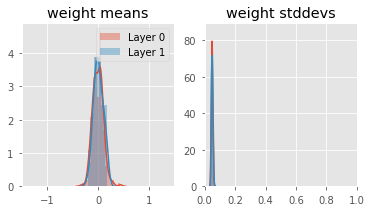

Step:   0 Loss: 0.739 Accuracy: 0.180
Step: 100 Loss: 0.625 Accuracy: 0.635


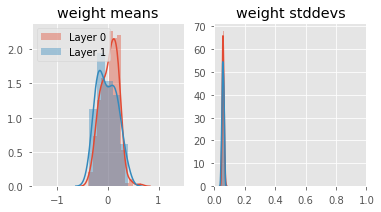

Step: 200 Loss: 0.526 Accuracy: 0.707
Step: 300 Loss: 0.552 Accuracy: 0.730


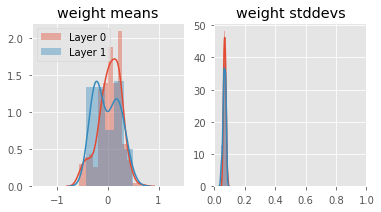

Step: 400 Loss: 0.566 Accuracy: 0.743
Step: 500 Loss: 0.523 Accuracy: 0.753


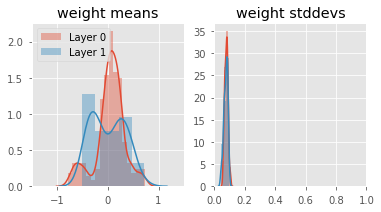

Step: 600 Loss: 0.530 Accuracy: 0.761
Step: 700 Loss: 0.526 Accuracy: 0.767


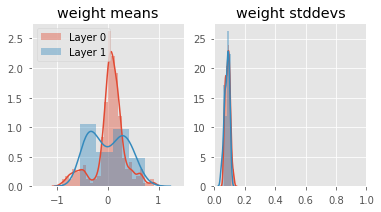

Step: 800 Loss: 0.542 Accuracy: 0.772
Step: 900 Loss: 0.551 Accuracy: 0.776


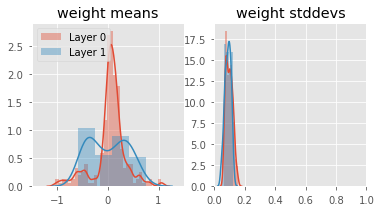

Step: 1000 Loss: 0.536 Accuracy: 0.779
Step: 1100 Loss: 0.532 Accuracy: 0.781


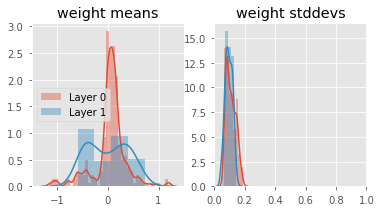

Step: 1200 Loss: 0.496 Accuracy: 0.784
Step: 1300 Loss: 0.558 Accuracy: 0.786


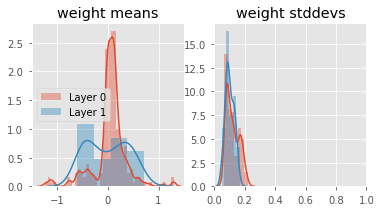

Step: 1400 Loss: 0.536 Accuracy: 0.788
Step: 1500 Loss: 0.467 Accuracy: 0.789


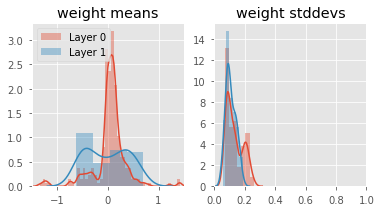

Step: 1600 Loss: 0.513 Accuracy: 0.790
Step: 1700 Loss: 0.531 Accuracy: 0.791


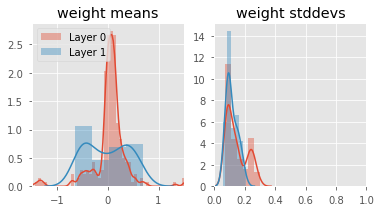

Step: 1800 Loss: 0.544 Accuracy: 0.793
Step: 1900 Loss: 0.492 Accuracy: 0.794


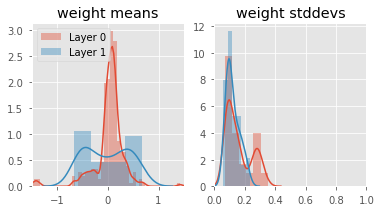

Wall time: 4min 54s


In [100]:
%%time
with tf.compat.v1.Session() as sess:
    sess.run(init_op)
    qm_vals, qs_vals = sess.run((qmeans, qstds))

    plot_weight_posteriors(names, qm_vals, qs_vals,fname=None)

    # Run the training loop.
    train_handle = sess.run(training_iterator.string_handle())
    heldout_handle = sess.run(heldout_iterator.string_handle())
    for step in range(max_steps):
        _ = sess.run([train_op, accuracy_update_op],
                   feed_dict={handle: train_handle})


        if step % 100 == 0:
            loss_value, accuracy_value = sess.run(
                [elbo_loss, accuracy], feed_dict={handle: train_handle})
            print("Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f}".format(
                step, loss_value, accuracy_value))
        if (step+1) % viz_steps == 0:
            qm_vals, qs_vals = sess.run((qmeans, qstds))

            plot_weight_posteriors(names, qm_vals, qs_vals,fname=None)
        if step+1 == 2000:
            probs = np.asarray([sess.run((labels_distribution.probs),
                                         feed_dict={handle: heldout_handle})
                                for _ in range(100)])

In [101]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,  np.mean(probs, axis=0)[:,1])
print('Baysiean Neural Network AUC', metrics.auc(fpr, tpr))

Baysiean Neural Network AUC 0.7716413895670672


In [114]:
np.mean(probs, axis=0)[:,1][:10]

array([0.26926097, 0.35496483, 0.27005798, 0.716927  , 0.42245241,
       0.27248478, 0.26945724, 0.26964056, 0.27196388, 0.26956835])

In [115]:
y_test.values[:10]

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [116]:
np.std(probs, axis=0)[:,1][:10]

array([0.00034302, 0.0519343 , 0.00129953, 0.00787801, 0.07323878,
       0.00381102, 0.00045013, 0.00084771, 0.00553755, 0.00051961])